In [1]:
%matplotlib inline

In [24]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np


In [25]:
conn = sqlite3.connect("../data/observations.db")
conn.execute("""ATTACH DATABASE '../data/demoddata.db' AS data;""")
conn.row_factory = sqlite3.Row

In [26]:
ground_station = 834

In [27]:
results = conn.execute("""
SELECT id
FROM times_index
WHERE start >= strftime('%s', '2022-01-01')
      -- AND ground_station = 834
      -- AND ground_station = 2380
      -- AND ground_station = 2550
      -- AND ground_station = 2
      -- AND ground_station = 2012
      
      -- same location, yagis in opposite directions
      -- AND ground_station = 1710
      -- AND ground_station = 2029
      
      -- PE0SAT
      -- AND ground_station = 2173
      -- AND ground_station = 2176
      
      AND ground_station = ?
ORDER BY start ASC;
""", [ground_station])

obs_ids = [x['id'] for x in results]

In [7]:
# get frames for each observation
# collect rows into lists
data_lens = []
azimuths = []
elevations = []
ranges = []
nones = 0
for obs_id in obs_ids:
    results = conn.execute("""
    SELECT id, length(data) as data_len, azimuth, elevation, range
    FROM data.obs_demoddata
    WHERE id = :id
    ORDER BY datetime ASC;""", [obs_id])
    
    for frame in results:
        # there may be some frames with no position information
        if frame['azimuth'] is None:
            nones += 1
            continue
        
        data_lens.append(frame['data_len'])
        azimuths.append(frame['azimuth'])
        elevations.append(frame['elevation'])
        ranges.append(frame['range'])
        
# numpy arrays for the data
data_lens = np.array(data_lens)
azimuths = np.array(azimuths)
elevations = np.array(elevations)
ranges = np.array(ranges)
#print(nones)
#print(len(data_lens))


## Frames per elevation angle

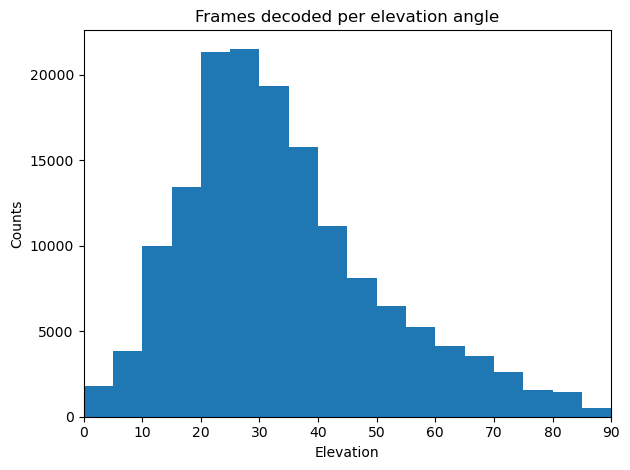

In [21]:
fig, ax = plt.subplots()
ax.hist(elevations, bins=range(0, 95, 5))
ax.set_xlabel('Elevation')
ax.set_ylabel('Counts')
ax.set_title('Frames decoded per elevation angle')
ax.set(xlim=(0, 90))
fig.tight_layout()

Remember, this is for a 2-axis pointing station, so the antenna is always pointing directly at the satellite.

- At high elevations, the along-track angular velocity is the greatest and thus there is **less time** spent pointing at these elevations, reducing the possible number of frames.
- There are **more passes** with lower maximum elevations, increasing the potential number of frames.
- At low elevations, the along-track angular velocity is the smallest and thuse **more** time spent at these angles, increasing the potential number of frames.

These combine to predict more frames at lower elevations, with the most near the horizon.
In this particular case, elevations below 15 degrees decoded fewer frames than expected by the prediction.

However, low elevations is where trees and buildings block the view.
Terrestrial noise sources are within the antenna's main lobe at low elevations.

## Frames by azimuth angle

Absent any knowledge of typical orbits, one might predict the azimuth distribution to be uniform.
Let's see what the distribution really was.

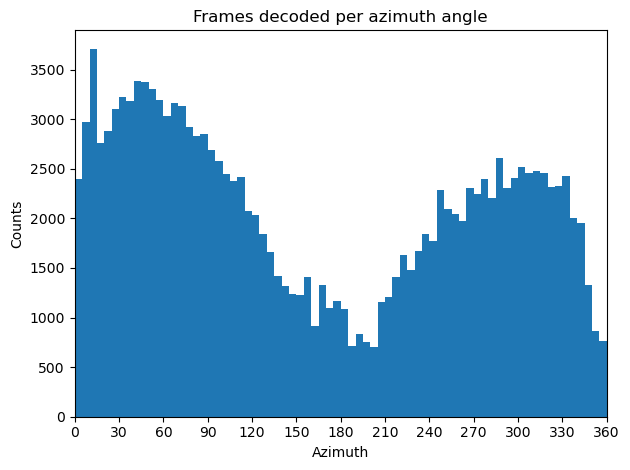

In [23]:
fig, ax = plt.subplots()
ax.hist(azimuths, bins=range(0, 365, 5))
ax.set(xlim=(0, 360), xticks=range(0, 365, 30))
ax.set_xlabel('Azimuth')
ax.set_ylabel('Counts')
ax.set_title('Frames decoded per azimuth angle')
fig.tight_layout()

That's interesting!

Western and Eastern directions are most "popular", with a narrow dip near North and a wide depression generally towards the South.

This is where we need to overlay this with the time-at-azimuth for the satellites we've been tracking with typical inclinations and our lattitude.


## Frames in 2d

In [33]:
azimuths_radians = azimuths * (np.pi / 180)
zenith_angle_degrees = (90 - elevations)
zenith_angle_radians = zenith_angle_degrees * (np.pi / 180)

def polar2z(r, theta):
    return r * np.exp(1j * theta)

def polar2xy(r, theta):
    z = polar2z(r, theta)
    return (z.real, z.imag)

def compass2xy(r, az):
    az_rad = az * (np.pi / 180)
    return polar2xy(r, -1*az_rad + np.pi/2)

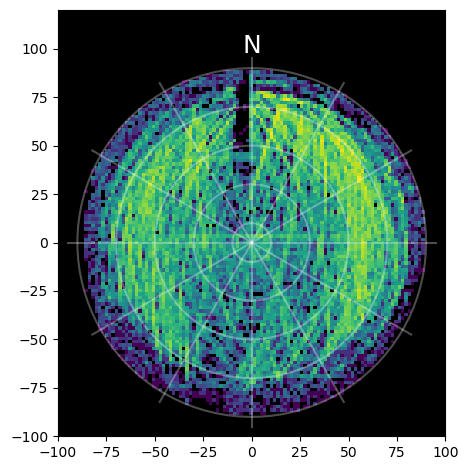

In [34]:
x, y = compass2xy(zenith_angle_degrees, azimuths)

from matplotlib import colors
fig, ax = plt.subplots(tight_layout=True)
hist = ax.hist2d(x, y, bins=101, norm=colors.LogNorm())
ax.set_aspect('equal')
ax.set(xlim=(-100, 100), ylim=(-100, 120))
ax.set_facecolor('black')
bins, xedges, yedges, _ = hist


# elevation circles
angle = np.linspace(0, 2*np.pi, 100)
for r in np.arange(90, 0, -20):
    ax.plot(r*np.cos(angle), r*np.sin(angle), color='white', alpha=0.3)

# azimuth rays
for a in range(0, 360, 30):
    a, b = compass2xy(95, a)
    ax.plot([0, a], [0, b], color='white', alpha=0.3)

_ = ax.text(0, 98, 'N', horizontalalignment='center', fontsize=18, color='white')

## How much data?

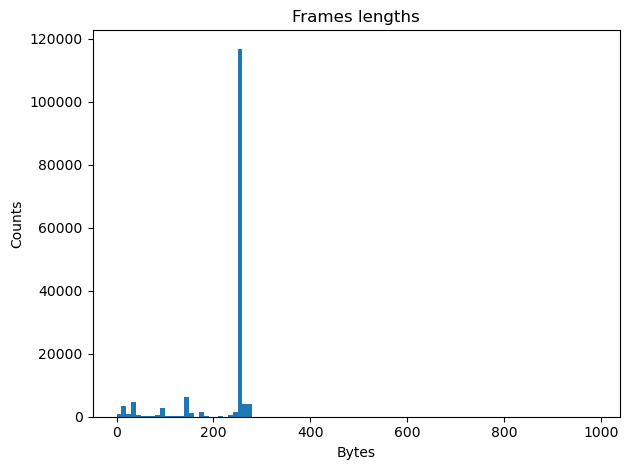

In [41]:
fig, ax = plt.subplots()
ax.hist(data_lens, bins=range(0, 1000, 10))
#ax.set(xlim=(0, 360), xticks=range(0, 365, 30))
ax.set_xlabel('Bytes')
ax.set_ylabel('Counts')
ax.set_title('Frames lengths')
fig.tight_layout()

In [36]:
np.min(data_lens)

5

In [37]:
np.max(data_lens)

603722